# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [209]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

### Data Loading

Here, we load the police call data for one year (2018) from CSV files. The data is then concatenated into a single DataFrame for analysis.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [212]:
# For testing purposes, just use one year's worth of data
police_csv_files = glob.glob("data/police/policecalls2018.csv.neighborhood.csv")

# List to hold dataframes
police_dfs = []

# Loop through the list of files and read them into dataframes
for file in police_csv_files:
    df = pd.read_csv(file)
    police_dfs.append(df)

# Concatenate all dataframes into one
all_police_df = pd.concat(police_dfs, ignore_index=True)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 322365


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [215]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
140325,20180609214038PD,7213169,5/14/2021 12:00:00 AM,P181600898,1,6/9/2018 12:00:00 AM,6/9/2018 12:00:00 AM,21:15:57,211SA,STRONG ARM ROBBERY,N,No report required; dispatch r,[700]-[800] THE ALAMEDA,San Jose,CA,37.340979,-121.923380,Alameda
220322,20180905022553PD,7333042,5/14/2021 12:00:00 AM,P182480058,2,9/5/2018 12:00:00 AM,9/5/2018 12:00:00 AM,02:17:24,415F,"DISTURBANCE, FAMILY",DUPNCAN,No Disposition,[100]-[200] LEWIS RD,San Jose,CA,37.294004,-121.843035,Umbarger
14738,20180118232853PS,7023071,5/14/2021 12:00:00 AM,P180180948,2,1/18/2018 12:00:00 AM,1/18/2018 12:00:00 AM,21:35:42,415F,"DISTURBANCE, FAMILY",CAN,Canceled,[1000]-[1100] S 5TH ST,San Jose,CA,37.329002,-121.879505,South University
108787,20180507173031PD,7166266,5/14/2021 12:00:00 AM,P181270689,2,5/7/2018 12:00:00 AM,5/7/2018 12:00:00 AM,17:13:17,911UNK,UNK TYPE 911 CALL,N,No report required; dispatch r,[1700]-[1800] HOPKINS DR,San Jose,CA,37.338937,-121.832958,Hillview
299495,20181204164632PS,7453397,5/14/2021 12:00:00 AM,P183380651,2,12/4/2018 12:00:00 AM,12/4/2018 12:00:00 AM,15:44:38,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch r,[500]-[600] COYOTE RD,San Jose,CA,37.279154,-121.818297,Coyote and Senter


In [217]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322365 entries, 0 to 322364
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              322365 non-null  object 
 1   EID               322365 non-null  int64  
 2   START_DATE        322365 non-null  object 
 3   CALL_NUMBER       322365 non-null  object 
 4   PRIORITY          322365 non-null  int64  
 5   REPORT_DATE       322365 non-null  object 
 6   OFFENSE_DATE      322365 non-null  object 
 7   OFFENSE_TIME      322365 non-null  object 
 8   CALLTYPE_CODE     322365 non-null  object 
 9   CALL_TYPE         322365 non-null  object 
 10  FINAL_DISPO_CODE  322365 non-null  object 
 11  FINAL_DISPO       322365 non-null  object 
 12  ADDRESS           312382 non-null  object 
 13  CITY              322365 non-null  object 
 14  STATE             322365 non-null  object 
 15  LATITUDE          289212 non-null  float64
 16  LONGITUDE         28

In [219]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.223650e+05,322365.000000,289212.000000,289212.000000
mean,7.244476e+06,3.335573,37.320203,-121.870827
std,1.402516e+05,1.395846,0.043354,0.048316
min,7.000038e+06,1.000000,34.018071,-122.035696
25%,7.123786e+06,2.000000,37.295263,-121.901964
50%,7.244217e+06,3.000000,37.323591,-121.868964
75%,7.365470e+06,4.000000,37.348403,-121.837675
max,7.488584e+06,6.000000,37.534539,-117.911791


In [221]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,322365,322365,322365,322365,322365,322365,322365,322365,322365,322365,312382,322365,322365,287681
unique,320127,1,316206,365,365,81044,213,206,22,18,31667,1,1,295
top,20180217091134PS,5/14/2021 12:00:00 AM,P181131012,2/9/2018 12:00:00 AM,2/9/2018 12:00:00 AM,18:51:14,415,DISTURBANCE,N,No report required; dispatch r,[1700]-[1800] AIRPORT BL,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,322365,6,1039,1039,21,30824,30824,141153,141153,1289,322365,322365,8599


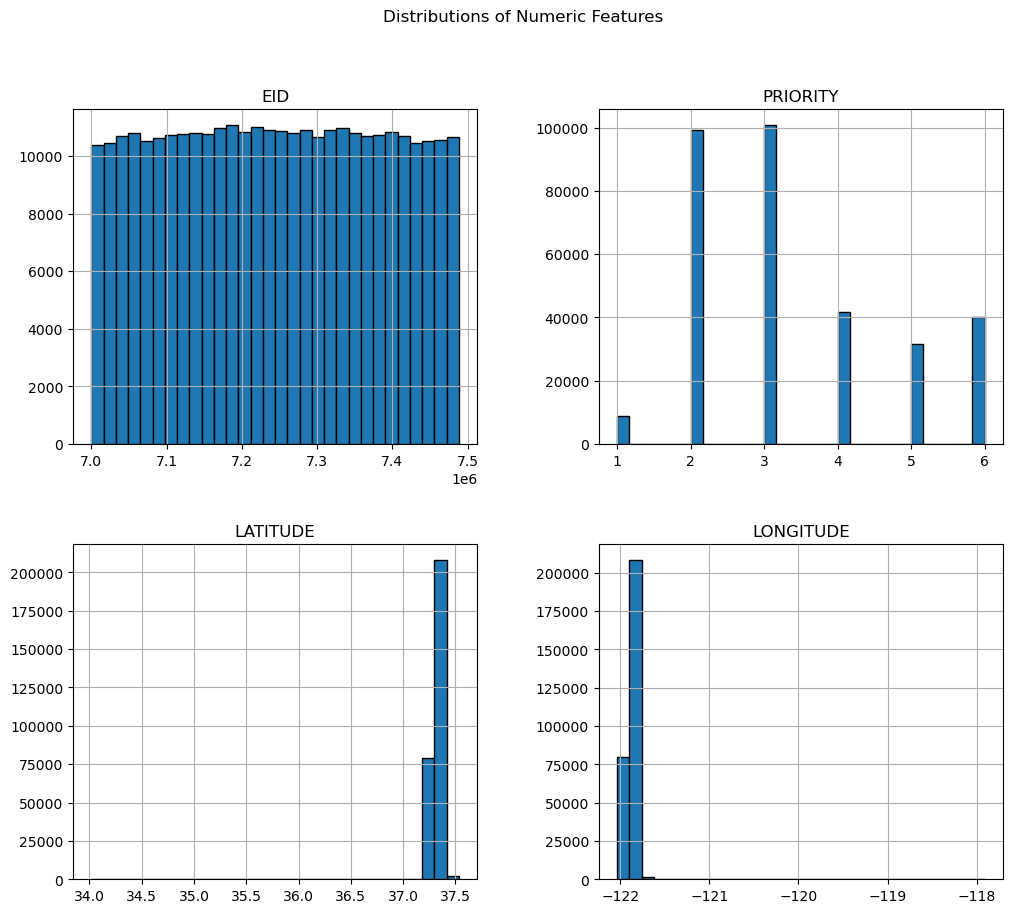

In [223]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [225]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              9983
CITY                    0
STATE                   0
LATITUDE            33153
LONGITUDE           33153
neighborhood        34684
dtype: int64

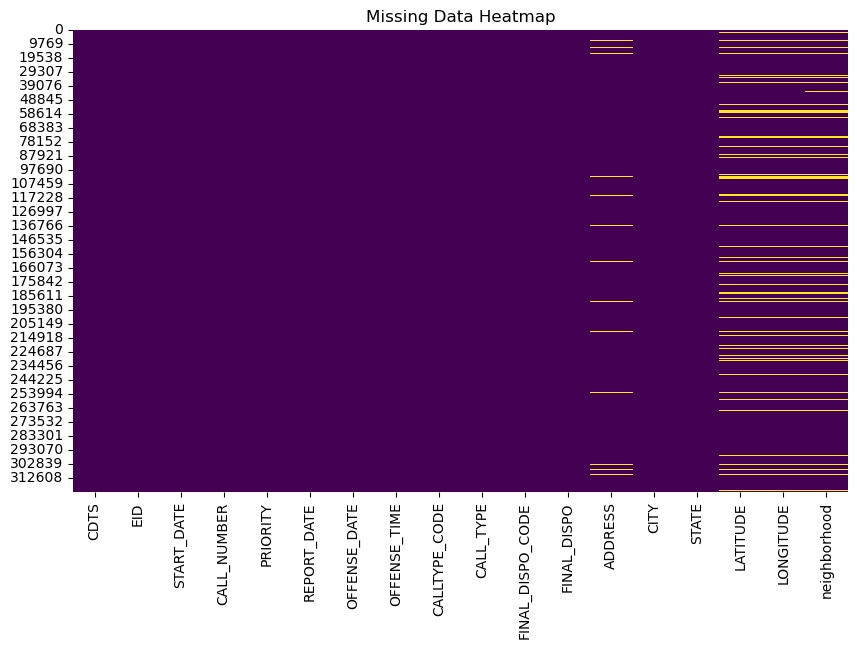

In [227]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [229]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 320127 unique values
START_DATE: 1 unique values
CALL_NUMBER: 316206 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 81044 unique values
CALLTYPE_CODE: 213 unique values
CALL_TYPE: 206 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31667 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [231]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          141153
CAN         42522
R           39976
G           21257
NR          13625
E           12319
D            8641
A            6429
DUPNCAN      5444
O            5245
H            4250
GD           4020
C            3854
B            3506
T            3217
U            2895
ADV          2783
F             980
M             105
Z              69
P              60
TOT            15
Name: count, dtype: int64

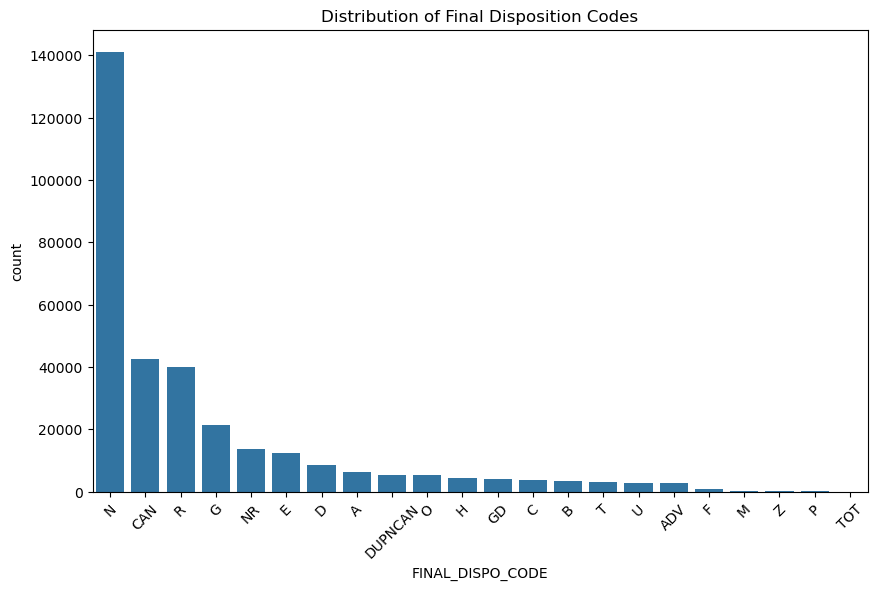

In [233]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [235]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    141153
Canceled                           42522
Report taken                       39976
Gone on Arrival/unable to loca     21257
No Response                        13625
No Disposition                     12331
Traffic Citation Issued, Non-H     12319
Traffic Citation Issued, Hazar      8641
Arrest Made                         6429
Supplemental report taken           5245
Courtesy Service/Citizen or ag      4250
Criminal Citation                   3854
Arrest by Warrant                   3506
Turned over To (TOT)                3217
Unfounded event                     2895
Field Interview (F.I.) Complet       980
Stranded motorist assist             105
Prior case, follow-up activity        60
Name: count, dtype: int64

In [237]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch r',
 'NR': 'No Response',
 'CAN': 'Canceled',
 'R': 'Report taken',
 'G': 'Gone on Arrival/unable to loca',
 'H': 'Courtesy Service/Citizen or ag',
 'GD': 'No Disposition',
 'DUPNCAN': 'No Disposition',
 'O': 'Supplemental report taken',
 'T': 'Turned over To (TOT)',
 'A': 'Arrest Made',
 'U': 'Unfounded event',
 'B': 'Arrest by Warrant',
 'E': 'Traffic Citation Issued, Non-H',
 'ADV': 'No Disposition',
 'D': 'Traffic Citation Issued, Hazar',
 'C': 'Criminal Citation',
 'F': 'Field Interview (F.I.) Complet',
 'Z': 'No Disposition',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity',
 'TOT': 'No Disposition'}

In [482]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 '1033A': 'ALARM, AUDIBLE',
 '415M': 'DISTURBANCE, MUSIC',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1057': 'FIREARMS DISCHARGED',
 'DVRO': 'VIOLATION OF PROTECTIVE ORDER',
 '415': 'DISTURBANCE',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAM',
 '5150': 'MENTALLY DISTURBED PERSON',
 '23103': 'RECKLESS DRIVING',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '242': 'BATTERY',
 '415F': 'DISTURBANCE, FAMILY',
 '10851': 'STOLEN VEHICLE',
 'AID': 'PUBLIC SAFETY ASSISTANCE',
 '1070': 'PROWLER',
 '415W': 'DISTURBANCE, WEAPON',
 '1066': 'SUSPICIOUS PERSON',
 'WELCK': 'WELFARE CHECK',
 '415A': 'DISTURBANCE, FIGHT',
 '911UNK': 'UNK TYPE 911 CALL',
 '1195': 'VEHICLE STOP',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '415AEMS': 'DISTURBANCE, FIGHT (COMBINED E',
 '1125': 'TRAFFIC HAZARD',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '1091C': 'INJURED ANIMAL',
 '246': 'SHOOTING INTO OCCP VEH OR DWEL',
 '23152': 'MISDEMEANOR DUI',
 '1091A': 'VICIOUS ANIMAL',
 '6F': 'FELONY WANT',
 '484

## Focus on Target Dispositions

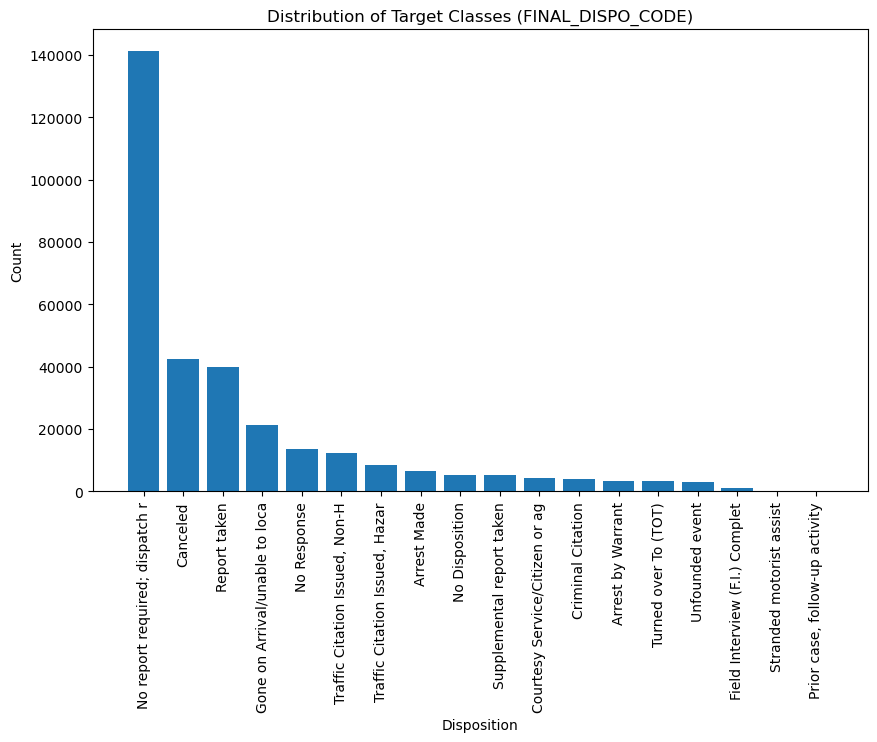

In [240]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [242]:
# List of target disposition codes to keep as individual classes
target_dispo_codes = ['A', 'B', 'C', 'D', 'E']

dispo_mapping = {
    'A': 'Arrest Made',
    'B': 'Arrest by Warrant',
    'C': 'Criminal Citation',
    'D': 'Traffic Citation Issued, Hazardous',
    'E': 'Traffic Citation Issued, Non-Hazardous',
    'Other': 'Other'
}

In [244]:
# Step 1: Create a new target variable where specified disposition codes remain,
# and all others are consolidated into a single class.
all_police_df['DISPO_SUBSET'] = np.where(all_police_df['FINAL_DISPO_CODE'].isin(target_dispo_codes), 
                                         all_police_df['FINAL_DISPO_CODE'], 'Other')
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    287616
E         12319
D          8641
A          6429
C          3854
B          3506
Name: count, dtype: int64

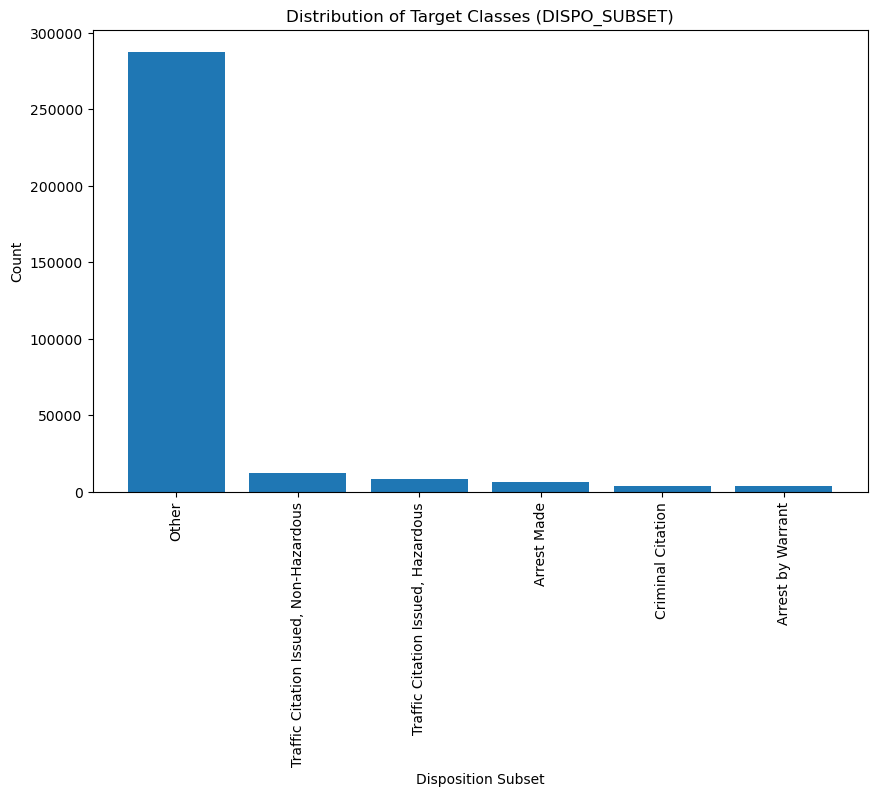

In [246]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Subset')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [278]:
# Remove rows with any missing values from the Police Calls dataset
police_calls_clean = all_police_df.dropna()
print(f"Police Calls Dataset: {all_police_df.shape[0]} rows before cleaning, {police_calls_clean.shape[0]} rows after cleaning.")

Police Calls Dataset: 322365 rows before cleaning, 287681 rows after cleaning.


In [282]:
# Dropping unnecessary columns 
police_calls_clean = police_calls_clean.drop( \
    columns=['CDTS', 'EID', 'CALL_NUMBER', 'START_DATE', 'REPORT_DATE', 'CITY', 'STATE', \
             'CALL_TYPE', 'FINAL_DISPO', 'FINAL_DISPO_CODE', 'ADDRESS'])

In [284]:
# Convert 'OFFENSE_DATE' to datetime to extract time-related features
police_calls_clean['OFFENSE_DATE'] = pd.to_datetime(police_calls_clean['OFFENSE_DATE'], format='%m/%d/%Y %I:%M:%S %p')

# and adding time-related features
police_calls_clean['OFFENSE_HOUR'] = police_calls_clean['OFFENSE_DATE'].dt.hour
police_calls_clean['OFFENSE_DAY_OF_WEEK'] = police_calls_clean['OFFENSE_DATE'].dt.dayofweek
police_calls_clean['OFFENSE_MONTH'] = police_calls_clean['OFFENSE_DATE'].dt.month

# Drop 'OFFENSE_DATE' now that features have been extracted
police_calls_clean = police_calls_clean.drop(columns=['OFFENSE_DATE', 'OFFENSE_TIME'])

# Distance from center: add a feature that
# San Jose's approximate center (Latitude and Longitude)
SJ_CENTER_LAT, SJ_CENTER_LON = 37.3382, -121.8863

# Calculate Euclidean distance from the city center
police_calls_clean['DISTANCE_FROM_CENTER'] = np.sqrt(
    (police_calls_clean['LATITUDE'] - SJ_CENTER_LAT) ** 2 + 
    (police_calls_clean['LONGITUDE'] - SJ_CENTER_LON) ** 2
)

In [296]:
# Normalize latitude and longitude before adding polynomial featuers
scaler = StandardScaler()
police_calls_clean[['LATITUDE', 'LONGITUDE']] = scaler.fit_transform(police_calls_clean[['LATITUDE', 'LONGITUDE']])

# Generate polynomial features from normalized latitude and longitude
poly = PolynomialFeatures(degree=2, include_bias=False)
lat_lon_poly = poly.fit_transform(police_calls_clean[['LATITUDE', 'LONGITUDE']])

# Create a DataFrame with the polynomial features and concatenate with original data
lat_lon_poly_df = pd.DataFrame(lat_lon_poly[:, 2:], \
                               columns=poly.get_feature_names_out(['LATITUDE', 'LONGITUDE'])[2:], \
                               index=police_calls_clean.index)

In [304]:
police_calls_clean = pd.concat([police_calls_clean, lat_lon_poly_df], axis=1)

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,DISPO_SUBSET,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
322360,2,415,0.071586,-1.128270,Parkmoor,Other,0,0,12,0.040363,0.005125,-0.080769,1.272992
322361,2,242,2.417488,-2.026405,Alviso,A,0,0,12,0.117005,5.844249,-4.898811,4.106319
322362,2,WELCK,-0.334851,-0.605185,Downtown Lincoln Ave,Other,0,0,12,0.034714,0.112125,0.202647,0.366249
322363,3,602PC,-1.777181,0.037938,Westfield Oakridge,Other,0,0,12,0.095589,3.158373,-0.067424,0.001439
322364,3,10851,-0.222873,-1.027910,Fruitdale and Sherman Oaks,Other,0,0,12,0.042770,0.049672,0.229093,1.056599


In [306]:
# Encode categorical columns using One-Hot Encoding
police_calls_encoded = pd.get_dummies(police_calls_clean, columns=['CALLTYPE_CODE', 'neighborhood'], drop_first=True)

## Define X and Y

In [310]:
# Define features and target
X = police_calls_encoded.drop(columns=['DISPO_SUBSET'])
y = police_calls_encoded['DISPO_SUBSET']

In [312]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [314]:
label_encoder.classes_

array(['A', 'B', 'C', 'D', 'E', 'Other'], dtype=object)

In [318]:
label_names = [dispo_mapping[code] for code in label_encoder.classes_]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_test_original = label_encoder.inverse_transform(y_test)
y_test_original_name = [dispo_mapping[code] for code in y_test_original]

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [320]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [322]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [324]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.00      0.00      0.00      1168
                     Arrest by Warrant       0.00      0.00      0.00       626
                     Criminal Citation       0.00      0.00      0.00       697
    Traffic Citation Issued, Hazardous       0.00      0.00      0.00      1568
Traffic Citation Issued, Non-Hazardous       0.00      0.00      0.00      2345
                                 Other       0.89      1.00      0.94     51133

                              accuracy                           0.89     57537
                             macro avg       0.15      0.17      0.16     57537
                          weighted avg       0.79      0.89      0.84     57537



### Logistic Regression

In [502]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print("DONE")

DONE


In [504]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.62      0.30      0.41      1168
                     Arrest by Warrant       0.69      0.54      0.60       626
                     Criminal Citation       0.45      0.18      0.25       697
    Traffic Citation Issued, Hazardous       0.71      0.41      0.52      1568
Traffic Citation Issued, Non-Hazardous       0.53      0.24      0.33      2345
                                 Other       0.92      0.98      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.65      0.44      0.51     57537
                          weighted avg       0.89      0.91      0.89     57537



#### Hyperparameter Tuning

In [517]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'] 
}

grid_search_scoring_method = 'f1_macro'

# Initialize Grid Search
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=-1, verbose=2, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l2'}


NameError: name 'grid_search_scorig_method' is not defined

In [519]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l2'}
Best Score (f1_macro): 0.5183


In [521]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_scaled)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                                        precision    recall  f1-score   support

                           Arrest Made       0.62      0.30      0.41      1168
                     Arrest by Warrant       0.69      0.54      0.61       626
                     Criminal Citation       0.45      0.18      0.25       697
    Traffic Citation Issued, Hazardous       0.71      0.41      0.52      1568
Traffic Citation Issued, Non-Hazardous       0.54      0.24      0.34      2345
                                 Other       0.92      0.98      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.65      0.44      0.51     57537
                          weighted avg       0.89      0.91      0.89     57537



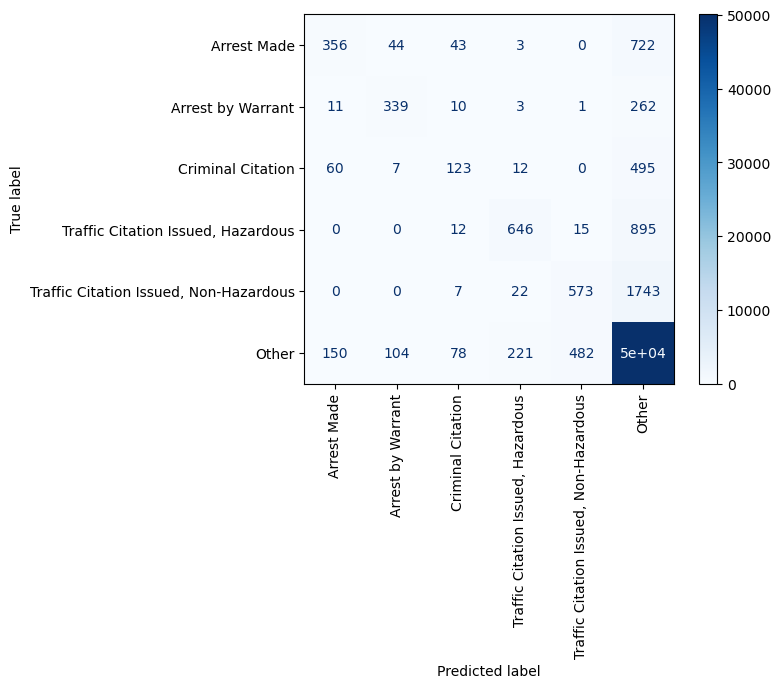

In [523]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test_scaled, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

#### Feature Importance

In [511]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
permutation_importance_result = permutation_importance(best_lr, X_test_scaled, y_test, n_repeats=10, random_state=42)

In [529]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping[code]
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top 10 features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(15)
print(top_perm_features)

                            Feature  Importance                 Call Type
102             CALLTYPE_CODE_22500    0.017267         PARKING VIOLATION
1                          LATITUDE    0.016534                          
135               CALLTYPE_CODE_415    0.015253               DISTURBANCE
9                       LONGITUDE^2    0.014759                          
78              CALLTYPE_CODE_1195X    0.008428    VEHICLE STOP ON FEMALE
219             CALLTYPE_CODE_WELCK    0.008169             WELFARE CHECK
8                LATITUDE LONGITUDE    0.006726                          
195                CALLTYPE_CODE_6M    0.006634          MISDEMEANOR WANT
32               CALLTYPE_CODE_1066    0.006347         SUSPICIOUS PERSON
231             neighborhood_Alviso    0.006088                          
140              CALLTYPE_CODE_415F    0.005953       DISTURBANCE, FAMILY
7                        LATITUDE^2    0.004694                          
6              DISTANCE_FROM_CENTER   

In [535]:
# Get the model's coefficients
coefficients = best_lr.coef_[0]

# Create a DataFrame of feature names and their corresponding coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Call Type': call_types
})

# Sort by the absolute value of the coefficients
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
top_10_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)

# Display the top 10 most important features
print(top_10_features[['Feature', 'Coefficient', 'Call Type']])

                  Feature  Coefficient                      Call Type
102   CALLTYPE_CODE_22500    -1.044994              PARKING VIOLATION
47   CALLTYPE_CODE_10851R     0.489701       RECOVERED STOLEN VEHICLE
77     CALLTYPE_CODE_1195    -0.405278                   VEHICLE STOP
107   CALLTYPE_CODE_23152     0.388058                MISDEMEANOR DUI
140    CALLTYPE_CODE_415F     0.353846            DISTURBANCE, FAMILY
213    CALLTYPE_CODE_DVRO     0.353019  VIOLATION OF PROTECTIVE ORDER
59     CALLTYPE_CODE_1124    -0.342405              ABANDONED VEHICLE
45    CALLTYPE_CODE_10851     0.342126                 STOLEN VEHICLE
11    CALLTYPE_CODE_1033A    -0.339377                 ALARM, AUDIBLE
180    CALLTYPE_CODE_601T     0.319233                  TRUANT (TABS)


### Random Forest

In [342]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs = -1)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [343]:
y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.51      0.25      0.34      1168
                     Arrest by Warrant       0.57      0.50      0.53       626
                     Criminal Citation       0.32      0.18      0.23       697
    Traffic Citation Issued, Hazardous       0.69      0.62      0.65      1568
Traffic Citation Issued, Non-Hazardous       0.49      0.38      0.43      2345
                                 Other       0.94      0.97      0.95     51133

                              accuracy                           0.90     57537
                             macro avg       0.59      0.48      0.52     57537
                          weighted avg       0.89      0.90      0.89     57537



#### Hyperparameter Tuning

In [539]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                              cv=5, n_jobs=1, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best Recall: 0.53


In [541]:
# Use the best estimator to make predictions
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.51      0.25      0.34      1168
                     Arrest by Warrant       0.57      0.50      0.53       626
                     Criminal Citation       0.32      0.18      0.23       697
    Traffic Citation Issued, Hazardous       0.69      0.62      0.65      1568
Traffic Citation Issued, Non-Hazardous       0.49      0.38      0.43      2345
                                 Other       0.94      0.97      0.95     51133

                              accuracy                           0.90     57537
                             macro avg       0.59      0.48      0.52     57537
                          weighted avg       0.89      0.90      0.89     57537



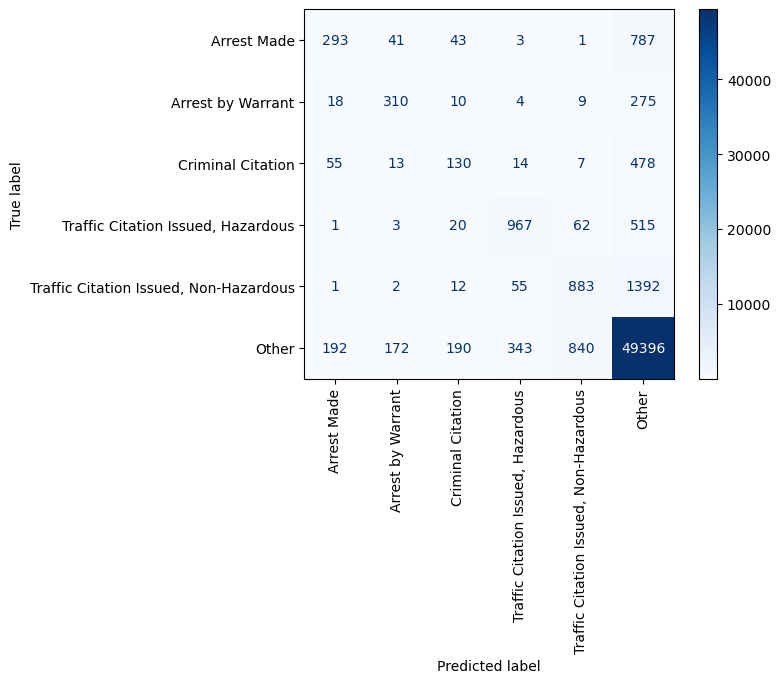

In [350]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_scaled, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

### Multilayer Perceptron Model

In [545]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Build the MLP model
mlp_model = Sequential()
mlp_model.add(Input(shape=(X_train_scaled.shape[1],)))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.2))  # Optional dropout to prevent overfitting
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [547]:
# Train the model
history = mlp_model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8905 - loss: 0.3762 - val_accuracy: 0.9050 - val_loss: 0.2751
Epoch 2/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9011 - loss: 0.2888 - val_accuracy: 0.9058 - val_loss: 0.2698
Epoch 3/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9025 - loss: 0.2791 - val_accuracy: 0.9064 - val_loss: 0.2699
Epoch 4/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9031 - loss: 0.2766 - val_accuracy: 0.9073 - val_loss: 0.2675
Epoch 5/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9055 - loss: 0.2708 - val_accuracy: 0.9074 - val_loss: 0.2689
Epoch 6/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9040 - loss: 0.2685 - val_accuracy: 0.9062 - val_loss: 0.2682
Epoch 7/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9071 - loss: 0.2644 - val_accuracy: 0.9083 - val_loss: 0.2664
Epoch 8/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9075 - loss: 0.2614 - 

In [549]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - accuracy: 0.9076 - loss: 0.2837
Test Accuracy: 0.9075


In [551]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test_scaled)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step
Neural Network Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.67      0.21      0.32      1168
                     Arrest by Warrant       0.68      0.53      0.60       626
                     Criminal Citation       0.42      0.23      0.30       697
    Traffic Citation Issued, Hazardous       0.74      0.49      0.59      1568
Traffic Citation Issued, Non-Hazardous       0.56      0.15      0.24      2345
                                 Other       0.92      0.98      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.67      0.43      0.50     57537
                          weighted avg       0.89      0.91      0.89     57537



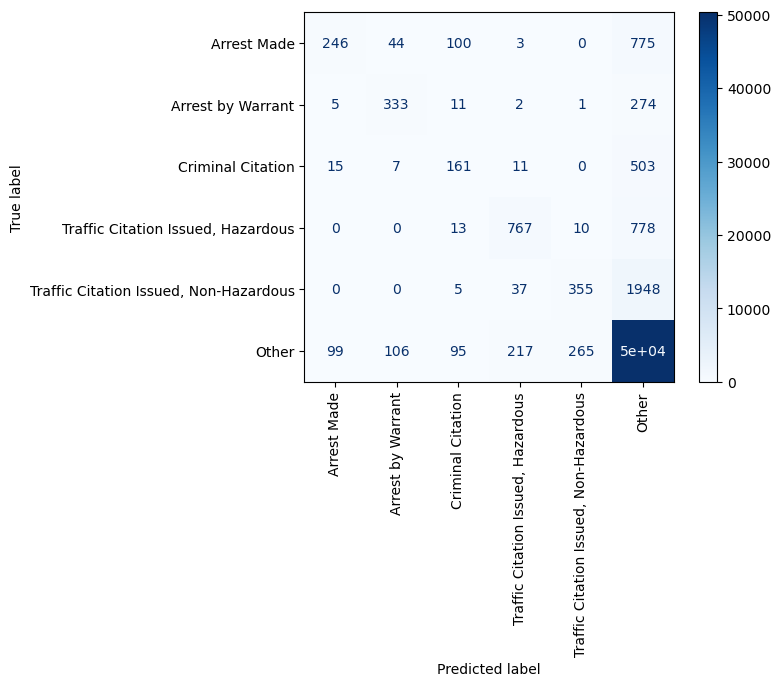

In [553]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

### Convolutional Neural Network

In [453]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Reshape the data to be 3D for 1D CNN: (samples, time steps, channels)
# Time steps = number of features, channels = 1
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Build the CNN model
cnn_model = models.Sequential()
cnn_model.add(layers.Input(shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [455]:
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.8960 - loss: 0.3313 - val_accuracy: 0.9042 - val_loss: 0.2693
Epoch 2/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.9066 - loss: 0.2691 - val_accuracy: 0.9069 - val_loss: 0.2692
Epoch 3/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.9071 - loss: 0.2674 - val_accuracy: 0.9100 - val_loss: 0.2637
Epoch 4/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - accuracy: 0.9094 - loss: 0.2618 - val_accuracy: 0.9093 - val_loss: 0.2626
Epoch 5/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - accuracy: 0.9101 - loss: 0.2575 - val_accuracy: 0.9098 - val_loss: 0.2658
Epoch 6/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.9120 - loss: 0.2533 - val_accuracy: 0.9079 - val_loss: 0.2657
Epoch 7/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.9119 - loss: 0.2508 - val_accuracy: 0.9103 - val_loss: 0.2661
Epoch 8/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.9130 -

In [459]:
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test)
cnn_accuracy = test_acc
print(f"Test Accuracy: {test_acc:.2f}")

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9069 - loss: 0.2832
Test Accuracy: 0.91


In [461]:
# Make predictions
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

cnn_recall = recall_score(y_test, y_pred_cnn_classes, average='macro')
cnn_f1 = f1_score(y_test, y_pred_cnn_classes, average='macro')

# Classification report
print(f"CNN Recall {cnn_recall}")
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn_classes, zero_division=0, target_names=label_names))

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
CNN Recall 0.4674365491645867
CNN Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.57      0.29      0.39      1168
                     Arrest by Warrant       0.69      0.54      0.60       626
                     Criminal Citation       0.42      0.21      0.28       697
    Traffic Citation Issued, Hazardous       0.71      0.53      0.61      1568
Traffic Citation Issued, Non-Hazardous       0.54      0.26      0.35      2345
                                 Other       0.93      0.98      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.64      0.47      0.53     57537
                          weighted avg       0.89      0.91      0.89     57537



## CNN #2
Trying out a slightly different convolutional neural network.

In [463]:
# Build the CNN model
cnn_model_2 = models.Sequential()
cnn_model_2.add(layers.Input(shape=(X_train_cnn.shape[1], 1)))
cnn_model_2.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model_2.add(layers.MaxPooling1D(pool_size=2))
cnn_model_2.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model_2.add(layers.MaxPooling1D(pool_size=2))
cnn_model_2.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model_2.add(layers.MaxPooling1D(pool_size=2))
cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(100, activation='relu'))
cnn_model_2.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
cnn_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [465]:
cnn_model_2.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 68s 24ms/step - accuracy: 0.8934 - loss: 0.3467 - val_accuracy: 0.9061 - val_loss: 0.2720
Epoch 2/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 68s 24ms/step - accuracy: 0.9054 - loss: 0.2757 - val_accuracy: 0.9087 - val_loss: 0.2755
Epoch 3/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 68s 24ms/step - accuracy: 0.9084 - loss: 0.2643 - val_accuracy: 0.9091 - val_loss: 0.2636
Epoch 4/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 68s 24ms/step - accuracy: 0.9087 - loss: 0.2637 - val_accuracy: 0.9107 - val_loss: 0.2662
Epoch 5/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 70s 24ms/step - accuracy: 0.9093 - loss: 0.2576 - val_accuracy: 0.9074 - val_loss: 0.2648
Epoch 6/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 68s 24ms/step - accuracy: 0.9125 - loss: 0.2529 - val_accuracy: 0.9094 - val_loss: 0.2648
Epoch 7/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 68s 24ms/step - accuracy: 0.9109 - loss: 0.2545 - val_accuracy: 0.9092 - val_loss: 0.2639
Epoch 8/10
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 70s 24ms/step - accuracy: 0.9133 -

In [469]:
# Make predictions
y_pred_cnn_2 = cnn_model_2.predict(X_test_cnn)
y_pred_cnn_2_classes = np.argmax(y_pred_cnn_2, axis=1)

cnn_2_accuracy = accuracy_score(y_test, y_pred_cnn_2_classes)
cnn_2_recall = recall_score(y_test, y_pred_cnn_2_classes, average='macro')
cnn_2_f1 = f1_score(y_test, y_pred_cnn_2_classes, average='macro')

# Classification report
print(f"CNN2 Recall {cnn_2_recall}")
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn_2_classes, zero_division=0, target_names=label_names))

1799/1799 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
CNN2 Recall 0.4712074745379187
CNN Classification Report:
                                        precision    recall  f1-score   support

                           Arrest Made       0.59      0.32      0.42      1168
                     Arrest by Warrant       0.68      0.54      0.60       626
                     Criminal Citation       0.41      0.26      0.32       697
    Traffic Citation Issued, Hazardous       0.78      0.44      0.56      1568
Traffic Citation Issued, Non-Hazardous       0.53      0.29      0.37      2345
                                 Other       0.93      0.98      0.95     51133

                              accuracy                           0.91     57537
                             macro avg       0.65      0.47      0.54     57537
                          weighted avg       0.89      0.91      0.90     57537



## Results

In [543]:
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'CNN'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, cnn_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, cnn_2_recall],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, cnn_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,F1-score
Model,,,
Baseline,0.888698,0.166667,0.156845
Logistic Regression,0.906113,0.443149,0.512597
Random Forest,0.903106,0.482227,0.521983
MLP,0.907590,0.441279,0.509702
CNN,0.907538,0.471207,0.537312
